# Attention Weight Full vs Sparse Study

In [5]:
!python cbii_mass_and_perf_full_vs_sparse.py \
  --device cuda --dtype fp16 \
  --max_tasks 0 --max_windows_per_task 3 \
  --probe_batch_size 4 --max_series_per_window 256 \
  --S_split 128 \
  --local_radius 8 --chunk_size 256 --backend flash \
  --perf_batch_size 256 \
  --perf_radii 8,16,32,64,128 \
  --out_prefix cbii_ctxQ4 \
  --perf_repeats 5


Loading weights: 100%|█| 170/170 [00:00<00:00, 862.18it/s, Materializing param=s
/opt/conda/lib/python3.10/site-packages/datasets/load.py:1231: FutureWarning: The repository for autogluon/chronos_datasets_extra contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/autogluon/chronos_datasets_extra
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Loading weights: 100%|█| 170/170 [00:00<00:00, 831.83it/s, Materializing param=s
/opt/conda/lib/python3.10/site-packages/datasets/load.py:1231: FutureWarning: The repository for autogluon/chronos_datasets_extra contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/autogluon/chronos_datasets_extra
You can avoid

In [8]:
import glob
import re
import numpy as np
import pandas as pd

# -------- config --------
PREFIX = "cbii_ctxQ4"
WRITE_CSV = True
OUT_CSV = f"{PREFIX}__perf_summary_by_radius.csv"

# -------- helpers --------
def extract_radius(path: str) -> int:
    m = re.search(r"_r(\d+)\.csv$", path)
    if not m:
        raise ValueError(f"Could not parse radius from filename: {path}")
    return int(m.group(1))

def to_num(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def safe_mean(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    return float(np.mean(x)) if x.size else float("nan")

def safe_median(x):
    x = np.asarray(x, dtype=np.float64)
    x = x[np.isfinite(x)]
    return float(np.median(x)) if x.size else float("nan")

# -------- main --------
compare_files = sorted(glob.glob(f"{PREFIX}__perf_compare_r*.csv"))
if not compare_files:
    raise RuntimeError(f"No files matched: {PREFIX}__perf_compare_r*.csv")

rows = []

for path in compare_files:
    r = extract_radius(path)
    df = pd.read_csv(path)

    # Make sure numeric cols are numeric
    num_cols = [
        "delta_metric",
        "speedup",
        "MASE_full", "MASE_sparse",
        "test_error_full", "test_error_sparse",
        "inference_time_s_median_full", "inference_time_s_median_sparse",
        "delta_peak_alloc_mb", "delta_peak_reserved_mb",
    ]
    df = to_num(df, num_cols)

    # Identify which metric columns exist
    if "MASE_full" in df.columns and "MASE_sparse" in df.columns:
        metric = "MASE"
        m_full = df["MASE_full"].to_numpy(dtype=np.float64)
        m_sparse = df["MASE_sparse"].to_numpy(dtype=np.float64)
    elif "test_error_full" in df.columns and "test_error_sparse" in df.columns:
        metric = "test_error"
        m_full = df["test_error_full"].to_numpy(dtype=np.float64)
        m_sparse = df["test_error_sparse"].to_numpy(dtype=np.float64)
    else:
        # Fallback: use delta only
        metric = "metric"
        m_full = np.full(len(df), np.nan, dtype=np.float64)
        m_sparse = np.full(len(df), np.nan, dtype=np.float64)

    delta = df["delta_metric"].to_numpy(dtype=np.float64)
    speed = df["speedup"].to_numpy(dtype=np.float64)

    # Pull p-value from per-radius t-test file if it exists
    p = float("nan")
    ttest_path = f"{PREFIX}__perf_ttest_r{r}.csv"
    try:
        tt = pd.read_csv(ttest_path)
        # prefer scipy p, else p_approx
        if "p" in tt.columns and len(tt):
            p = float(pd.to_numeric(tt["p"], errors="coerce").iloc[0])
        elif "p_approx" in tt.columns and len(tt):
            p = float(pd.to_numeric(tt["p_approx"], errors="coerce").iloc[0])
    except FileNotFoundError:
        pass

    rows.append({
        "radius": r,
        "n_tasks": int(df["task_name"].nunique()) if "task_name" in df.columns else int(len(df)),
        "metric": metric,
        "mean_delta_metric": safe_mean(delta),
        "median_delta_metric": safe_median(delta),
        "max_abs_delta_metric": safe_mean(np.abs(delta)) if np.isfinite(delta).any() else float("nan"),
        "mean_speedup": safe_mean(speed),
        "median_speedup": safe_median(speed),
        "metric_full_mean": safe_mean(m_full),
        "metric_sparse_mean": safe_mean(m_sparse),
        "p_value": p,
    })

out = pd.DataFrame(rows).sort_values("radius").reset_index(drop=True)

# Clean, minimal print (no pandas truncation)
with pd.option_context("display.max_columns", None, "display.width", 200):
    print(out.to_string(index=False))

if WRITE_CSV:
    out.to_csv(OUT_CSV, index=False)
    print(f"\nWrote: {OUT_CSV}")


 radius  n_tasks metric  mean_delta_metric  median_delta_metric  max_abs_delta_metric  mean_speedup  median_speedup  metric_full_mean  metric_sparse_mean  p_value
      8       27   MASE          -0.001650            -0.000086              0.001830      0.973380        0.965846          9.212416            9.210766 0.107531
     16       27   MASE           0.000038            -0.000091              0.000749      0.964814        0.959966          9.212416            9.212454 0.887393
     32       27   MASE           0.000365             0.000009              0.000647      0.966601        0.960674          9.212416            9.212781 0.288954
     64       27   MASE          -0.000642            -0.000117              0.000914      0.968655        0.961477          9.212416            9.211774 0.221018
    128       27   MASE           0.001011            -0.000032              0.001414      0.969692        0.963810          9.212416            9.213427 0.219545

Wrote: cbii_ctxQ4__pe

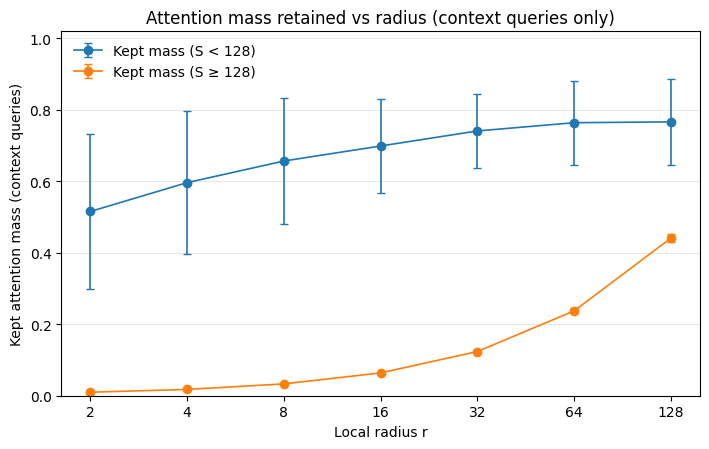

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MASS_SUMMARY = "cbii_ctxQ2__mass_summary.csv"

mass = pd.read_csv(MASS_SUMMARY)

# ---------------------------
# Kept mass vs radius (clean)
# ---------------------------
r = mass["radius"].to_numpy()

y_small = mass["kept_mass_mean_ctxQ_S<128"].to_numpy()
e_small = mass["kept_mass_std_ctxQ_S<128"].to_numpy()

y_large = mass["kept_mass_mean_ctxQ_S>=128"].to_numpy()
e_large = mass["kept_mass_std_ctxQ_S>=128"].to_numpy()

# Optional: overlay kept-edge fraction if present
edge_small_col = "kept_edges_mean_ctxQ_S<128"
edge_large_col = "kept_edges_mean_ctxQ_S>=128"
has_edges = (edge_small_col in mass.columns) and (edge_large_col in mass.columns)

fig, ax = plt.subplots(figsize=(7.2, 4.6))

ax.errorbar(
    r, y_small, yerr=e_small,
    marker="o", capsize=3, linewidth=1.2,
    label="Kept mass (S < 128)"
)
ax.errorbar(
    r, y_large, yerr=e_large,
    marker="o", capsize=3, linewidth=1.2,
    label="Kept mass (S ≥ 128)"
)

ax.set_xscale("log", base=2)
ax.set_xticks(r)
ax.set_xticklabels([str(int(x)) for x in r])
ax.set_ylim(0, 1.02)
ax.set_xlabel("Local radius r")
ax.set_ylabel("Kept attention mass (context queries)")
ax.set_title("Attention mass retained vs radius (context queries only)")
ax.grid(True, which="both", axis="y", linewidth=0.6, alpha=0.35)

# Optional overlay: kept edge fraction (dashed, right axis)
if has_edges:
    ax2 = ax.twinx()
    ax2.plot(
        r, mass[edge_small_col].to_numpy(),
        linestyle="--", linewidth=1.2, label="Kept edges (S < 128)"
    )
    ax2.plot(
        r, mass[edge_large_col].to_numpy(),
        linestyle="--", linewidth=1.2, label="Kept edges (S ≥ 128)"
    )
    ax2.set_ylim(0, 1.02)
    ax2.set_ylabel("Kept edge fraction")

    # Combine legends cleanly
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc="lower right")
else:
    ax.legend(frameon=False, loc="upper left")

fig.tight_layout()
plt.show()
